# Kod
Dużo go, zacznę go przerzucać do osobnego pliku od następnych labów

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

def MSE(x, y):
    return np.sum((x - y)**2) / len(x)

def lin_act(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Layer:   
    def __init__(self, neurons, input_shape, weights, bias, activation):
        self.neurons = neurons
        self.input_shape = input_shape
        
        assert weights.shape == (input_shape[1], neurons)
        self.weights = weights
        
        assert bias.shape == (1, neurons)
        self.bias = bias
        
        self.activation = activation
        self.last_a = None
    
    
    def make_factory(neurons, input_shape, activation, factory):
        return Layer(
            neurons = neurons,
            input_shape = input_shape,
            weights = factory((input_shape[1], neurons)),
            bias = factory((1, neurons)),
            activation = activation
        )
    
    def make_zero(neurons, input_shape, activation):
        return Layer.make_factory(neurons, input_shape, activation, np.zeros)
    
    def make_random(neurons, input_shape, activation):
        random_balanced = lambda shape: np.random.random(shape) - 0.5
        return Layer.make_factory(neurons, input_shape, activation, random_balanced)
    
    def apply(self, inputs):
        intensities = inputs @ self.weights
        self.last_a = intensities + self.bias
        return self.activation(intensities + self.bias)
    
    def apply_no_intensities(self, inputs):
        intensities = inputs @ self.weights
        return self.activation(intensities + self.bias)
    
    def __str__(self):
        return f"LAYER(\nW:\n {repr(self.weights)} \nb:\n{repr(self.bias)})\n"
    
    def __repr__(self):
        return str(self)


class NN:
    def __init__(self, *layers, input_shape):
        self.input_shape = input_shape
        self.layers = [*layers]
        self.errors = None
        self.last_inputs = None
        
    def get_last_shape(self):
        if self.layers:
            return self.layers[-1].weights.shape
        else:
            return self.input_shape
    
    def add_new_zero_layer(self, neurons, activation=sigmoid):
        layer = Layer.make_zero(
            neurons,
            self.get_last_shape(),
            activation
        )
        self.layers.append(layer)
        return layer
    
    def add_new_random_layer(self, neurons, activation=sigmoid):
        layer = Layer.make_random(
            neurons,
            self.get_last_shape(),
            activation
        )
        self.layers.append(layer)
        return layer
        
    def apply(self, inputs):
        self.last_inputs = inputs
        x = inputs
        for layer in self.layers:
            x = layer.apply(x)
        return x
    
    def calculate_errors(self, yhat, y):
        errors = [None] * len(self.layers)
        errors[-1] = (yhat - y)
        for i in range(len(errors)-2, -1, -1):
            uhm = errors[i+1] @ np.transpose(self.layers[i+1].weights)
            errors[i] = grad_sigmoid(self.layers[i].last_a) * uhm
        return errors
    
    def calculate_grads(self, errors):
        grad = [None] * len(self.layers)
        grad_b = [None] * len(self.layers)
        
        for k in range(len(errors)):
            if k == 0:
                f_a = self.layers[0].activation(self.last_inputs)
            else:
                cur_layer = self.layers[k-1]
                f_a = cur_layer.activation(cur_layer.last_a)
            
            grad[k] = np.transpose(f_a) @ errors[k]
            grad_b[k] = errors[k] 
        return grad, grad_b
    
    def get_zero_grads(self):
        grad = [None] * len(self.layers)
        grad_b = [None] * len(self.layers)
        for i, layer in enumerate(self.layers):
            grad[i] = np.zeros(layer.weights.shape)
            grad_b[i] = np.zeros(layer.bias.shape)
        return grad, grad_b
    
    def backpropagate(self, yhat, y):
        errors = self.calculate_errors(yhat, y)
        return self.calculate_grads(errors)
    
    def gradient_descent(self, x, y, rate=1e-3):
        sumg, sumgb = self.get_zero_grads()
            
        for i, x_i in enumerate(x):
            yhat = self.apply(x_i)
            g, gb = self.backpropagate(yhat, y[i])
            for i in range(len(self.layers)):
                sumg[i]  -= rate * g[i]
                sumgb[i] -= rate * gb[i]
        
        for i in range(len(self.layers)):
            self.layers[i].weights += sumg[i]/x.shape[0]
            self.layers[i].bias += sumgb[i]/x.shape[0]
            
    def batch_descent(self, x, y, rate=1e-3, batch_size=x.shape[0]//10):
        indexes = np.random.randint(x.shape[0], size=(batch_size, 1))
        x_chosen = x[indexes]
        y_chosen = y[indexes]
        
        self.gradient_descent(x_chosen, y_chosen, rate=rate)
            
    def stochastic_descent(self, x, y, rate=1e-3):
        index = np.random.randint(x.shape[0])
        x_i = x[index]
        y_i = y[index]
        yhat_i = self.apply(x_i)
        g, gb = self.backpropagate(yhat_i, y_i)
        for i in range(len(self.layers)):
            self.layers[i].weights -= rate*g[i]
            self.layers[i].bias -= rate*gb[i]

# Simple squares

## Dane i architektura
Odpowiednio: 1, 15, 15, 1 neuronów. Ostatnia warstwa z liniową funkcją aktywacji.

In [111]:
df = pd.read_csv("LAB1_DANE/regression/square-simple-training.csv")
x = np.array(df.iloc[:,1]).reshape((100, 1))
y = np.array(df.iloc[:,2]).reshape((100, 1))

df_test = pd.read_csv("LAB1_DANE/regression/square-simple-test.csv")
x_test = np.array(df_test.iloc[:,1]).reshape((100, 1))
y_test = np.array(df_test.iloc[:,2]).reshape((100, 1))

In [110]:
nn = NN(input_shape=(0,1))
h1 = nn.add_new_random_layer(15)
h2 = nn.add_new_random_layer(15)
ol = nn.add_new_random_layer(1, activation=lin_act)

## Problem
Napotkałem się z problemem, gdzie sieć nie jest w stanie nauczyć się spadków.
Z tego powodu, tworzy się dosyć dziwny wykres, który wygląda jakby sieć nie dostawała części wzorców.

### Demonstracja

In [166]:
nn1 = NN(input_shape=(0,1))
h11 = nn1.add_new_random_layer(15)
h21 = nn1.add_new_random_layer(15)
ol1 = nn1.add_new_random_layer(1, activation=lin_act)

In [175]:
for _ in range(10000):
    nn1.gradient_descent(x, y)


MSE (train): 2422.8


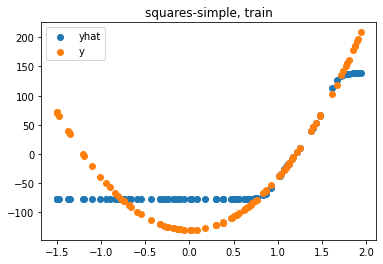

In [176]:
print(f"MSE (train): {MSE(nn1.apply(x), y):.5}")

plt.scatter(
    x,
    nn1.apply(x)
)

plt.scatter(
    x,
    y
)
plt.title("squares-simple, train")
plt.legend(["yhat", "y"])
plt.show()

### Diagnoza
Problem znajduje się w wagach. Ponieważ wagi początkowe znajdują się w okolicy 0, to są "ściągane" w dół, sprawiając, że wszystkie są podobnej wielkości, przez co sieć znajduje (słabe) lokalne minimum i nie może z niego wyjść.

In [192]:
ol1

LAYER(
W:
 array([[-15.65601668],
       [-14.75661811],
       [-12.36834769],
       [-14.93839096],
       [-16.50373577],
       [-13.86340039],
       [-10.21365373],
       [-14.78214688],
       [-15.3897255 ],
       [-11.91598382],
       [-15.18219832],
       [-15.7719353 ],
       [-15.65109233],
       [-14.95721629],
       [-15.3796919 ]]) 
b:
array([[139.52406983]]))

In [195]:
h11

LAYER(
W:
 array([[ 2.11905099, -0.98417761,  2.50940426,  2.1791902 , -1.11348819,
         2.21376362, -2.24709782, -2.42136183, -2.9211759 , -1.91946932,
        -2.46723701,  2.72943849,  0.74477006, -2.24351148, -1.25825142]]) 
b:
array([[-2.0650371 ,  0.94827604, -3.03281191, -2.19627025,  1.21406242,
        -2.33844867,  3.36438612,  3.57742074,  4.79093895,  2.57764608,
         3.82911425, -2.53166633,  0.06189781,  3.046385  ,  1.50416305]]))

### Rozwiązanie 1: Wybicie wag
Najprostszy sposób jaki znalazłem, to zwiększenie zakresu (wybicie) wag. Dzięki temu jest duża szansa, że nie każda waga się zminusuje. Nie jest to najbardziej eleganckie rozwiązanie, ale zadziałało i udało mi się nauczyć sieć zbioru `squares-simple`.

In [ ]:
h1.weights *= 30
h2.weights *= 30
ol.weights *= 30

### Rozwiązanie 2: Skalowanie y
Oryginalnie chciałem pokazać, że ta metoda mi nie działa, ale chyba miałem błąd w implementacji `gradient_descent`. Po ponownym uruchomieniu zadziałało, tylko potrzebne są odpowiednio większe `rate`, ponieważ w przeciwnym wypadku gradienty są zbyt małe, i bardzo długo zbiega do niezłego rozwiązania.

In [181]:
def make_scaler(x_vec):
    x_max = np.max(x_vec)
    x_min = np.min(x_vec)
    def scaler(x):
        nonlocal x_max, x_min
        return (x - x_min) / (x_max - x_min)
    def rev_scaler(x):
        nonlocal x_max, x_min
        return x * (x_max - x_min) + x_min
    return scaler, rev_scaler

In [182]:
scaler_ssq, rscaler_ssq = make_scaler(y)
y_s = scaler_ssq(y)

In [191]:
y[1]

array([-129.94284392])

In [190]:
rscaler_ssq(scaler_ssq(y))[1]

array([-129.94284392])

In [218]:
nn2 = NN(input_shape=(0,1))
h12 = nn2.add_new_random_layer(15)
h22 = nn2.add_new_random_layer(15)
ol2 = nn2.add_new_random_layer(1, activation=lin_act)

In [219]:
for i in range(10000):
    nn2.gradient_descent(x, y_s, rate=.5)
    if i % 100 == 0:
        mse = MSE(rscaler_ssq(nn2.apply(x)),y)
        print('\r', mse, end='')

 110.18050545189693

MSE (train): 110.18


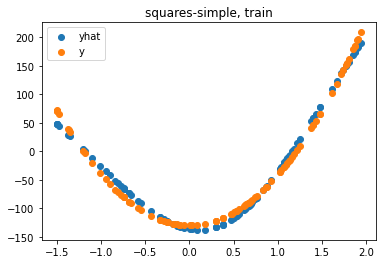

In [220]:
print(f"MSE (train): {MSE(rscaler_ssq(nn2.apply(x)), y):.5}")

plt.scatter(
    x,
    rscaler_ssq(nn2.apply(x))
)

plt.scatter(
    x,
    y
)
plt.title("squares-simple, train")
plt.legend(["yhat", "y"])
plt.show()

## Trening
*(Wykorzystałem metodę wybicia wag, bo myślałem, że skalowanie nie działa.)*

Jedna obserwacja w zbiorze testowym jest spoza zakresu zbioru treningowego.
Dla wyniku poniżej 4.0 trzeba było zejść **bardzo** nisko z MSE na treningowym. 
Plus jest taki, że testowana sieć jest w miarę mała, więc nie ma problemu z przeuczeniem.

Do zwykłego algorytmu nauczania dorzuciłem:
* redukcję prędkości uczenia, gdy zejdzie poniżej 100 MSE
* złamanie pętli, gdy MSE zejdzie do porządanego poziomu.
* raportowanie MSE na bierząco

In [162]:
rate = 0.01
mse = float("inf")
for i in range(1000000):
    nn.gradient_descent(x, y, rate=rate)
    if i % 100 == 0:
        mse = MSE(nn.apply(x),y)
        print('\r', mse, end='')
        if mse <= 100.0:
            rate = 0.001
        if mse <= 0.5:
            break

 0.49911774527583186

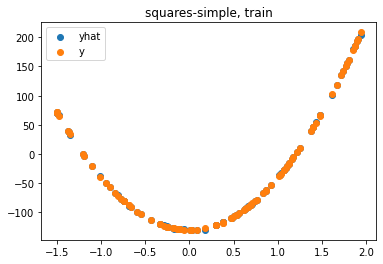

In [173]:
plt.scatter(
    x,
    nn.apply(x)
)

plt.scatter(
    x,
    y
)
plt.title("squares-simple, train")
plt.legend(["yhat", "y"])
plt.show()

MSE (test): 3.6543


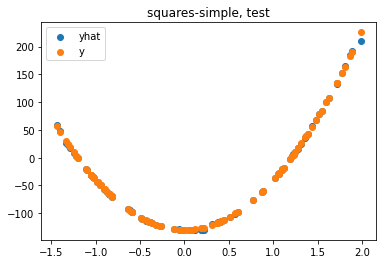

In [172]:
print(f"MSE (test): {MSE(nn.apply(x_test), y_test):.5}")
plt.scatter(
    x_test,
    nn.apply(x_test)
)

plt.scatter(
    x_test,
    y_test
)
plt.title("squares-simple, test")
plt.legend(["yhat", "y"])
plt.show()

In [ ]:
with open("nn_sq_v2.pickle", "wb") as f:
    pickle.dump(nn, f)
    
with open("nn_sq_v2.txt", "w") as f:
    f.write(str(nn))

# Steps small
## Dane i architektura

In [427]:
df2 = pd.read_csv("LAB1_DANE/regression/steps-small-training.csv")
df2_test = pd.read_csv("LAB1_DANE/regression/steps-small-test.csv")

In [428]:
x2 = np.array(df2.iloc[:,1]).reshape((50, 1))
y2 = np.array(df2.iloc[:,2]).reshape((50, 1))

step_sc, step_rsc = make_scaler(y2)
y2_sc = step_sc(y2)

x2_test = np.array(df2_test.iloc[:,1]).reshape((50, 1))
y2_test = np.array(df2_test.iloc[:,2]).reshape((50, 1))

In [549]:
nnss = NN(input_shape=(0, 1))
hl1ss = nnss.add_new_random_layer(8)
hl1ss.weights += .5
hl1ss.bias *= 0
olss = nnss.add_new_random_layer(1, activation=lin_act)
olss.weights += .5
olss.bias *= 0

## Problem 1: Regresja liniowa
Algorytm nie jest w stanie się nauczyć schodków i zatrzymuje się na poziomie wykonania regresji liniowej przez punkty.

### Demonstracja

In [590]:
p1nn = NN(input_shape=(0, 1))
p1hl = p1nn.add_new_random_layer(16)
p1ol = p1nn.add_new_random_layer(1, activation=lin_act)

In [591]:
for _ in range(1000):
    p1nn.gradient_descent(x2, y2_sc, rate=0.1)

383.79874297537054


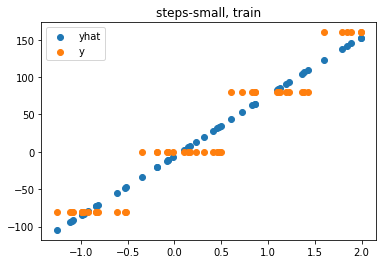

In [592]:
print(MSE(step_rsc(p1nn.apply(x2)),y2))
plt.scatter(
    x2,
    step_rsc(p1nn.apply(x2))
)

plt.scatter(
    x2,
    y2
)
plt.title("steps-small, train")
plt.legend(["yhat", "y"])
plt.show()

### Diagnoza
Jest to najprawdopodobniej spowodowane dziwnymi gradientami w przypadku tej funkcji skokowej. Z jej powodu algorytm "wkopuje" się w minimum lokalne i nie może z niego wyjść. 

### Rozwiązanie
Problem udało się rozwiązać za pomocą zmiany sposobu uczenia. Zamiast korzystać z pełnego gradientu, to korzystam z *stochastic descent*, który liczy dla każdej wartości osobno gradienty (odpowiednik *batch* dla 1 obserwacji). Taki algorytm jest bardziej chaotyczny, ale jest w stanie się wybić z minimum lokalnego i znaleźć bardziej optymalne rozwiązania.

## Problem 2: Zawinięty ogon
Dane testowe wychodzą poza zakres treningowych. To jest problemem, ponieważ dla małych MSE dla zbioru treningowego okazuje się, że są bardzo słabe wyniki dla testowego. Tworzy się dla wystających danych "ogon".

### Demonstracja

In [608]:
p2nn = NN(input_shape=(0, 1))
p2hl = p2nn.add_new_random_layer(32)
p2ol = p2nn.add_new_random_layer(1, activation=lin_act)

In [609]:
for i in range(10000000):
    p2nn.stochastic_descent(x2, y2_sc, rate=0.25)
    if i % 5000 == 0:
        mse = MSE(step_rsc(p2nn.apply(x2)),y2)
        print('\r', mse, end='')
        if mse <= 250:
            break

 248.27922178071992

248.27922178071992


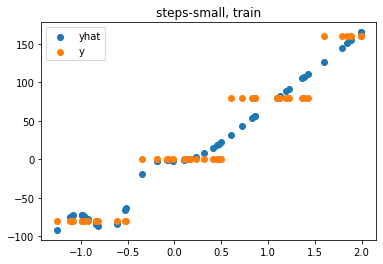

In [610]:
print(MSE(step_rsc(p2nn.apply(x2)),y2))
plt.scatter(
    x2,
    step_rsc(p2nn.apply(x2))
)

plt.scatter(
    x2,
    y2
)
plt.title("steps-small, train")
plt.legend(["yhat", "y"])
plt.show()

582.6331997101529


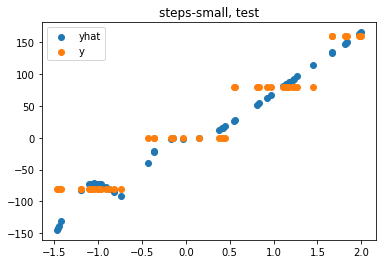

In [611]:
print(MSE(step_rsc(p2nn.apply(x2_test)),y2_test))
plt.scatter(
    x2_test,
    step_rsc(p2nn.apply(x2_test))
)

plt.scatter(
    x2_test,
    y2_test
)
plt.title("steps-small, test")
plt.legend(["yhat", "y"])
plt.show()

*Punkty w (-1.5, -150.0)*

### Diagnoza
Takie zachowanie jest spowodowane "wypychaniem" skoków poza zakres danych treningowych. To powoduje, że niektóre neurony nie mają wpływu na predykcję, ale nie są potrzebne. Te neurony często mają dziwne wagi, które nie są zmieniane, ponieważ mają bardzo mały wpływ na decyzję całej sieci. Te neurony jednak powodują duże problemy na zbiorze testowym, gdzie już mają wpływ.

### Rozwiązanie
Zerując `bias` dla każdej z warstw, przesuwam miejsca skoków w okolice x = 0.0. Dzięki temu jak będzie się zmieniać ich pozycja podczas uczenia, to jest mniejsze prawdopodobieństwo, że zostaną wypchnięte za granicę danych treningowych. Dodatkowo zredukowałem liczbę neuronów.

In [ ]:
rate = 0.25
for i in range(100000000):  
    nnss.stochastic_descent(x2, y2_sc, rate=rate) # odpowiednik batch z 1 próbką, ale trochę szybszy
    if i % 5000 == 0:
        mse = MSE(step_rsc(nnss.apply(x2)),y2)
        print('\r', mse, end='')
        if mse <= 100:
            rate = 0.1
        if mse <= 25:
            rate = 0.05
        if mse <= 10:
            rate = 0.01
        if mse <= 2.0:
            break
        mses.append(mse)


9.589890479347432


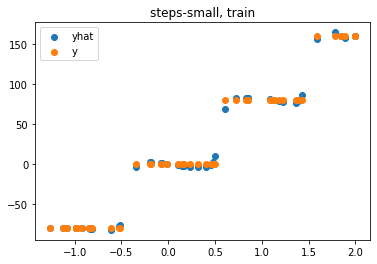

In [632]:
print(MSE(step_rsc(nnss.apply(x2)),y2))
plt.scatter(
    x2,
    step_rsc(nnss.apply(x2))
)

plt.scatter(
    x2,
    y2
)
plt.title("steps-small, train")
plt.legend(["yhat", "y"])
plt.show()

111.13679040206812


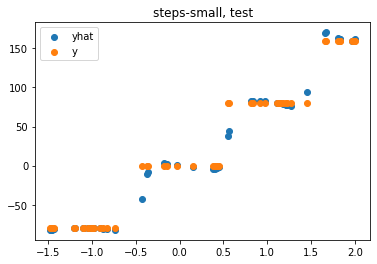

In [633]:
print(MSE(step_rsc(nnss.apply(x2_test)),y2_test))
plt.scatter(
    x2_test,
    step_rsc(nnss.apply(x2_test))
)

plt.scatter(
    x2_test,
    y2_test
)
plt.title("steps-small, test")
plt.legend(["yhat", "y"])
plt.show()

Nie jestem w stanie niżej zejść, sieć się uczyła łącznie 15 godzin. Próbowałem douczać na pełnym gradiencie, na batchach, nic nie działa. Dla własnego zdrowia psychicznego poddaję się.

In [691]:
len(mses) * 5000, len(mses)

(371775000, 74355)

371 milionów pokazanych wzorców...

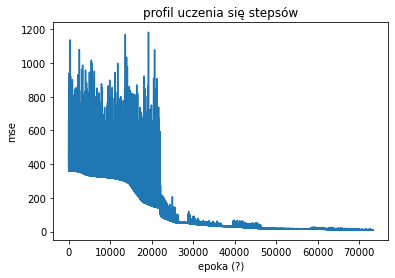

In [692]:
plt.plot(mses[1000:])
plt.title("profil uczenia się stepsów")
plt.ylabel("mse")
plt.xlabel("epoka (?)")
plt.show()

In [634]:
with open("nn_step_v3.pickle", "wb") as f:
    pickle.dump(nnss, f)
    
with open("nn_step_v3.txt", "w") as f:
    f.write(str(nnss))

# Multimodal
Bardzo długo się uczył, ale nie sprawiał dużych problemów. Oczywiście trzeba tutaj zastosować batchowanie, bo jest dużo danych. Batchowałem po 10 do osiągnięcia mniej więcej kształtu funkcji, później zwiększyłem do 50, żeby lepiej dopasować się do funkcji.

In [374]:
dfmm = pd.read_csv("LAB1_DANE/regression/multimodal-large-training.csv")
xmm = np.array(dfmm.iloc[:,0]).reshape((10000, 1))
ymm = np.array(dfmm.iloc[:,1]).reshape((10000, 1))
mm_sc, mm_rsc = make_scaler(ymm)
ymm_sc = mm_sc(ymm)

dfmm_test = pd.read_csv("LAB1_DANE/regression/multimodal-large-test.csv")
xmm_test = np.array(dfmm_test.iloc[:,0]).reshape((1000, 1))
ymm_test = np.array(dfmm_test.iloc[:,1]).reshape((1000, 1))

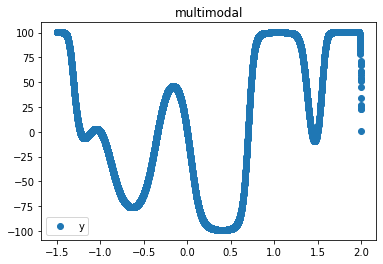

In [695]:
plt.scatter(
    xmm, ymm
)
plt.title("multimodal")
plt.legend(["y"])
plt.show()

In [361]:
nnmm = NN(input_shape=(0,1))
hl1mm = nnmm.add_new_random_layer(32)
hl2mm = nnmm.add_new_random_layer(32)
olmm = nnmm.add_new_random_layer(1, activation=lin_act)

In [379]:
rate=0.25
batch_size = 10
for i in range(10000000):
    nnmm.batch_descent(xmm, ymm_sc, rate=0.25, batch_size=batch_size)
    if i % 1000 == 0:
        mse = MSE(mm_rsc(nnmm.apply(xmm)),ymm)
        print('\r', mse, end='')
        if mse <= 100:
            batch_size = 50
        elif mse <= 1000:
            rate = 0.01
        if mse <= 30.0:
            break
print(i)

 29.96333490026052433000


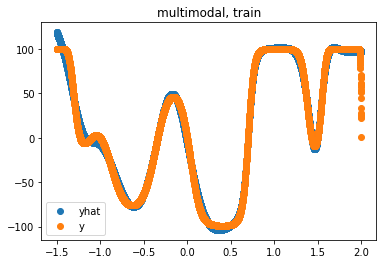

In [693]:
plt.scatter(
    xmm, mm_rsc(nnmm.apply(xmm))
)
plt.scatter(
    xmm, ymm
)
plt.title("multimodal, train")
plt.legend(["yhat", "y"])
plt.show()

26.15924334086995


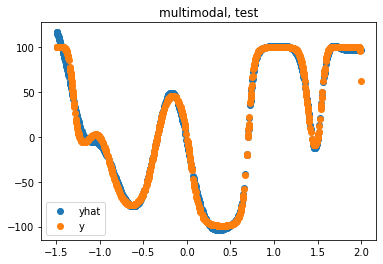

In [694]:
print(MSE(mm_rsc(nnmm.apply(xmm_test)),ymm_test))

plt.scatter(
    xmm_test, mm_rsc(nnmm.apply(xmm_test))
)
plt.scatter(
    xmm_test, ymm_test
)
plt.title("multimodal, test")
plt.legend(["yhat", "y"])
plt.show()

In [383]:
with open("nn_mm_v2.pickle", "wb") as f:
    pickle.dump(nnmm, f)
    
with open("nn_mm_v2.txt", "w") as f:
    f.write(str(nnmm))

# Szybkości zbieżności
Przetestuję na zbiorze squares, on najlepiej chyba współpracował. Przetestuję pełny gradient descent (100 wzorców), batchowy (po 10 wzorców) i stochastyczny (1 wzorzec). Każda sieć będzie trenowana przez 10s.

In [674]:
nngd = NN(input_shape=(0,1))
nngd.add_new_random_layer(16)
nngd.add_new_random_layer(16)
nngd.add_new_random_layer(1, activation=lin_act)
rmses_gd = []

nnbd = NN(input_shape=(0,1))
nnbd.add_new_random_layer(16)
nnbd.add_new_random_layer(16)
nnbd.add_new_random_layer(1, activation=lin_act)
rmses_bd = []

nnsd = NN(input_shape=(0,1))
nnsd.add_new_random_layer(16)
nnsd.add_new_random_layer(16)
nnsd.add_new_random_layer(1, activation=lin_act)
rmses_sd = []

In [675]:
import time
num_iter = 100000
batch_modifier = 1

t = time.time_ns()
for i in range(num_iter):
    nngd.gradient_descent(x, y_s, rate=.5)
    if i % 10 == 0:
        mse = MSE(rscaler_ssq(nngd.apply(x)),y)
        print('\r', mse, end='')
        rmses_gd.append((time.time_ns() - t ,mse))
        if (time.time_ns() - t) * 1e-9 > 10:
            break
print("")

t = time.time_ns()
for i in range(num_iter):
    nnbd.batch_descent(x, y_s, rate=.5, batch_size=10)
    if i % 100 == 0:
        mse = MSE(rscaler_ssq(nnbd.apply(x)),y)
        print('\r', mse, end='')
        rmses_bd.append((time.time_ns() - t ,mse))
        if (time.time_ns() - t) * 1e-9 > 10:
            break
print("")

t = time.time_ns()
for i in range(num_iter):
    nnsd.stochastic_descent(x, y_s, rate=.5)
    if i % 100 == 0:
        mse = MSE(rscaler_ssq(nnsd.apply(x)),y)
        print('\r', mse, end='')
        rmses_sd.append((time.time_ns() - t ,mse))
        if (time.time_ns() - t) * 1e-9 > 10:
            break

 6916.7218631227665
 54.575821684093234
 2.9725198563050834

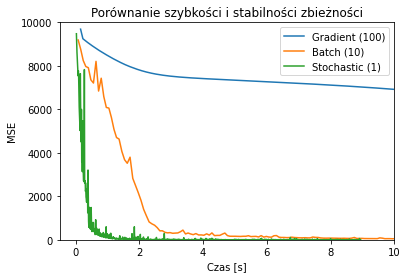

In [681]:
def plot_series(series):
    plt.plot(
        [tt*1e-9 for tt, vv in series if vv < 10_000],
        [vv for _, vv in series if vv < 10_000],
    )
plot_series(rmses_gd)
plot_series(rmses_bd)
plot_series(rmses_sd)
plt.xlim(-0.5, 10)
plt.ylim(0, 10_000)
plt.legend(["Gradient (100)", "Batch (10)", "Stochastic (1)"])
plt.ylabel("MSE")
plt.xlabel("Czas [s]")
plt.title("Porównanie szybkości i stabilności zbieżności")
plt.show()

Wyniki są dokładnie takie, jakie można się spodziewać. Gradient descent jest najwolniejszy, batchowanie jest znacznie szybsze i im mniejszy batch tym szybciej idzie. Ale też widać braki stabilności spadku w przypadku metod pokazywania części wzorców.

*Wiem, że nie ma w raporcie wizualizacji wag, ale nie czułem w żadnej chwili pracy nad tym punktem kontrolnym, że mi się do czegokolwiek przyda. Dlatego ją pominąłem. Nie napotkałem się z problemem eksplozji wag, a co znalazłem to na podstawie wartości liczbowych. Z kolei ciężko zrobić dobrą wizualizację jak są tysiące parametrów.*